# Setup

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Data cleaning

In [ ]:
# Load dataset from bigquery
%%bigquery df
SELECT *
FROM
    `data.container`

In [ ]:
# Alternatively, you can load the dataset from your local drive
filepath = '../data/'
df = pd.read_csv(filepath + 'ecomm_dataset.csv')

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
df.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
109950738,2019-11-30 23:59:58 UTC,view,15700137,2053013559733912211,NaN,NaN,277.74,532714000,02b4131c-0112-4231-aafa-ceaa08e77c1b
109950739,2019-11-30 23:59:58 UTC,view,28719425,2053013565639492569,apparel.shoes,baden,62.81,545223467,734c5eef-0742-4f8b-9d22-48f75b0bc359
109950740,2019-11-30 23:59:59 UTC,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb
109950741,2019-11-30 23:59:59 UTC,view,2701706,2053013563911439225,appliances.kitchen.refrigerators,samsung,566.27,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0
109950742,2019-11-30 23:59:59 UTC,view,1004233,2053013555631882655,electronics.smartphone,apple,1312.52,579969851,90aca71c-ed8a-4670-866a-761ebacb732d


### Deal with NaN (missing) values

In [ ]:
# Get counts of missing values per column
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    35413780
brand            15341158
price                   0
user_id                 0
user_session           12
dtype: int64

#### For category_code
From dataset uploader: Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.
Solution: Change NaN to 'none'

#### For brand
From dataset uploader: Downcased string of brand name. Can be missed.
Solution: Change NaN to 'none'

#### For user_session
From dataset uploader: Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.
Solution: Change NaN to 'none'

In [ ]:
# Replace NaN with str 'none'
df[['category_code','brand','user_session']] = df[['category_code','brand','user_session']].fillna('none')

In [ ]:
# check
df.isna().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

# Feature engineering

### Get product category

In [ ]:
# Function to extract the category (highest category level from category_code)
def get_category(text):
    category = text.split('.')[0]
    return category

In [ ]:
df['category'] = df['category_code'].apply(lambda x: get_category(x))

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,none,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,none
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,none,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics


### Get product category level 2

In [ ]:
# Function to extract the category (highest category level from category_code)
def get_category_l2(text):
    category_2 = text.split('.')[1]
    return category_2

In [ ]:
df['category_2'] = df['category_code'].apply(lambda x: get_category_l2(x))

In [ ]:
df.head()

### Convert event_time (str) to datetime

In [ ]:
# Convert event_time to datetime format
df['datetime'] = pd.to_datetime(df['event_time'])

# Split datetime column
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['time'] = pd.to_datetime(df['datetime']).dt.time
df['day'] = pd.to_datetime(df['datetime']).dt.day_name()

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,datetime,date,time,day
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,none,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,none,2019-10-01 00:00:00+00:00,2019-10-01,00:00:00,Tuesday
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,2019-10-01 00:00:00+00:00,2019-10-01,00:00:00,Tuesday
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,none,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,2019-10-01 00:00:01+00:00,2019-10-01,00:00:01,Tuesday
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01 00:00:01+00:00,2019-10-01,00:00:01,Tuesday
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,2019-10-01 00:00:04+00:00,2019-10-01,00:00:04,Tuesday


# EDA

In [ ]:
# Set default plotting style
style.use('tableau-colorblind10')
sns.set_theme(style='darkgrid')

In [ ]:
# Plot distribution of event type
# Get number of events per event_type
event_type_count = df.groupby('event_type')['event_type'].count()
print(event_type_count)
print()

event_type
cart          3955446
purchase      1659788
view        104335509
Name: event_type, dtype: int64



In [ ]:
df['event_type'].value_counts(normalize=True)

view        0.948930
cart        0.035975
purchase    0.015096
Name: event_type, dtype: float64

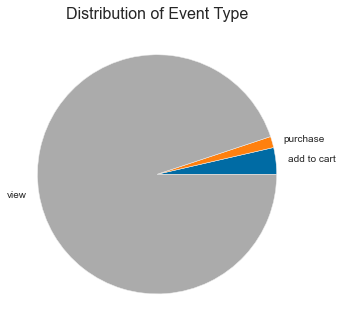

In [ ]:
# Plot pie chart
labels = ['add to cart', 'purchase', 'view']
plt.title('Distribution of Event Type', fontsize=16)
plt.pie(event_type_count, labels=labels)
plt.show()

In [ ]:
# Create df of purchase events
event_purchase = df.loc[df['event_type']=='purchase']

IOStream.flush timed out


In [ ]:
event_purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,datetime,date,time,day
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,2019-10-01 00:02:14+00:00,2019-10-01,00:02:14,Tuesday
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,2019-10-01 00:04:37+00:00,2019-10-01,00:04:37,Tuesday
379,2019-10-01 00:06:02 UTC,purchase,5100816,2053013553375346967,none,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,none,2019-10-01 00:06:02+00:00,2019-10-01,00:06:02,Tuesday
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,2019-10-01 00:07:07+00:00,2019-10-01,00:07:07,Tuesday
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,2019-10-01 00:09:26+00:00,2019-10-01,00:09:26,Tuesday


In [ ]:
event_purchase.shape

(1659788, 14)

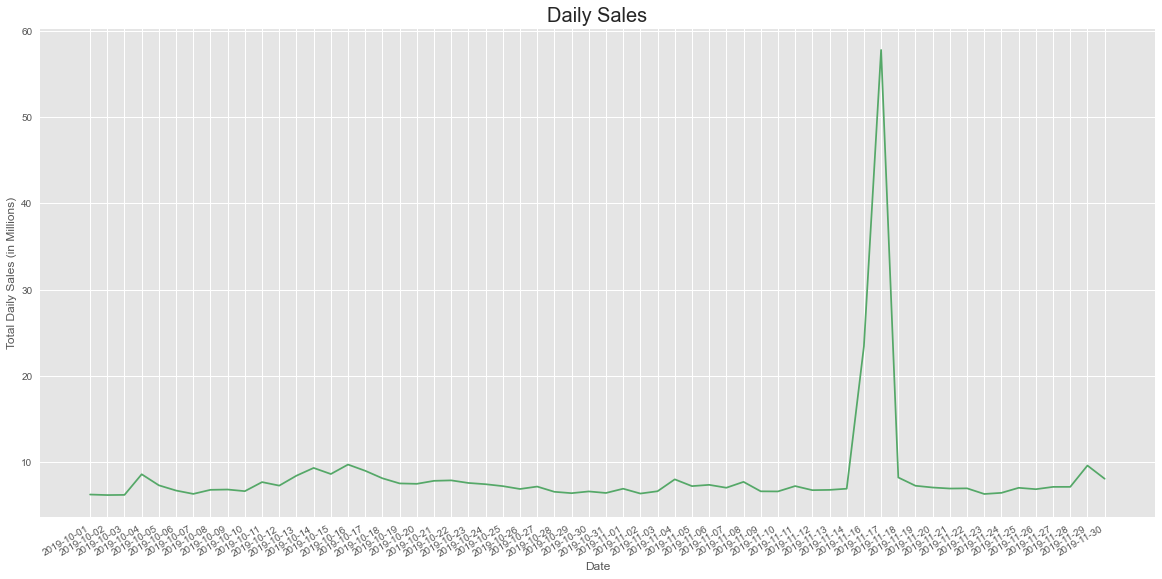

In [ ]:
# Plot daily sales

# Create df for plotting
plot_df = pd.DataFrame(event_purchase[['date','price']].groupby(event_purchase['date']).sum().reset_index(),index=None)

# Create line plot
x = plot_df['date']
y = plot_df['price']/1e7
fig = plt.figure(figsize=(20,10))
plt.plot(x, y, color='g')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Daily Sales (in Millions)', fontsize=12)
plt.title('Daily Sales', fontsize=20)
fig.autofmt_xdate()
plt.show()

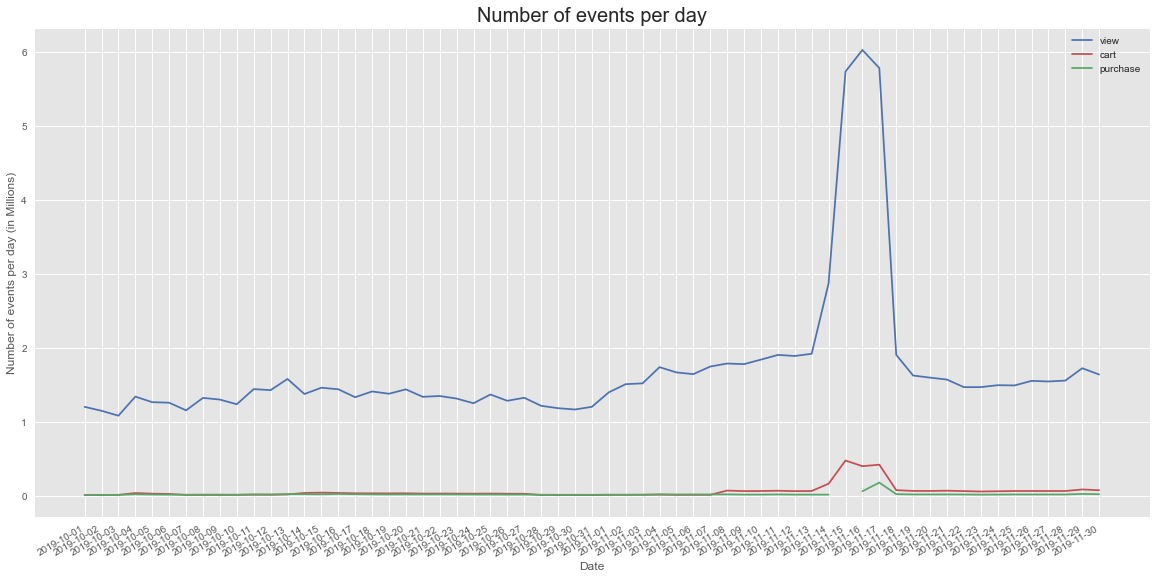

In [ ]:
# Plot daily counts of events per event type

# Create df for plotting
x = df[['date','event_type']].groupby('date').value_counts().reset_index()
pivot_df = x.pivot(index='date', columns='event_type').reset_index()

# Create line plot
fig = plt.figure(figsize=(20,10))
plt.plot(pivot_df['date'], pivot_df[0]['view']/1e6, color='b') # event_type = view
plt.plot(pivot_df['date'], pivot_df[0]['cart']/1e6, color='r') # event_type = cart
plt.plot(pivot_df['date'], pivot_df[0]['purchase']/1e6, color='g') # event_type = purchase
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of events per day (in Millions)', fontsize=12)
plt.title('Number of events per day', fontsize=20)
plt.legend(labels=['view','cart','purchase'])
fig.autofmt_xdate()
plt.show()

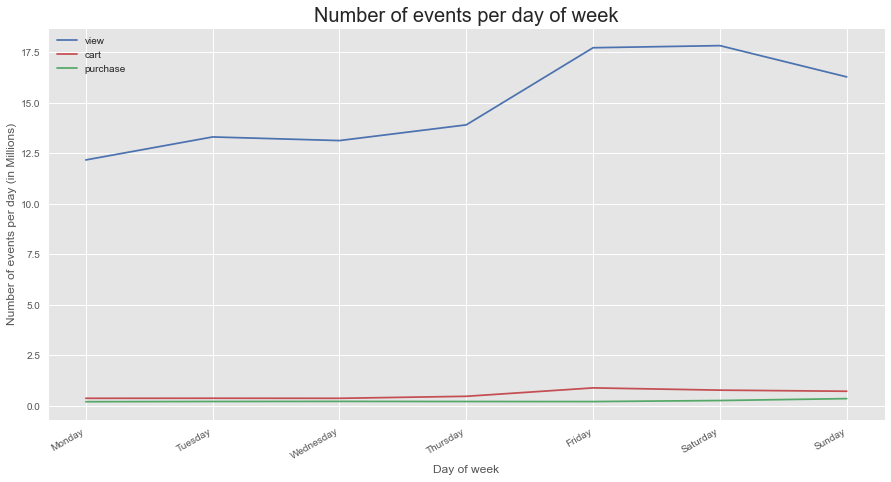

In [ ]:
# Plot counts of events per day of week

# Create df for plotting
x = df[['day','event_type']].groupby('day').value_counts().reset_index()

# Order by day of week
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
x['day'] = pd.Categorical(x['day'], categories=days, ordered=True)
x = x.sort_values('day')

# Create line plot
fig = plt.figure(figsize=(15,8))
plt.plot(x.loc[x['event_type']=='view']['day'], x.loc[x['event_type']=='view'][0]/1e6, color='b') # event_type = view
plt.plot(x.loc[x['event_type']=='cart']['day'], x.loc[x['event_type']=='cart'][0]/1e6, color='r') # event_type = cart
plt.plot(x.loc[x['event_type']=='purchase']['day'], x.loc[x['event_type']=='purchase'][0]/1e6, color='g') # event_type = purchase
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Number of events per day (in Millions)', fontsize=12)
plt.title('Number of events per day of week', fontsize=20)
plt.legend(labels=['view','cart','purchase'])
fig.autofmt_xdate()
plt.show()

### Shopping cart abandonment metrics

$$\mathrm{Shopping~cart~conversion~rate}=\frac{\mathrm{total~number~of~purchase~events}}{\mathrm{total~number~of~cart~events}} $$

In [ ]:
# Overall shopping cart conversion rate
df.groupby('event_type')['event_type'].count()[1]/df.groupby('event_type')['event_type'].count()[0]

0.41962094792850163

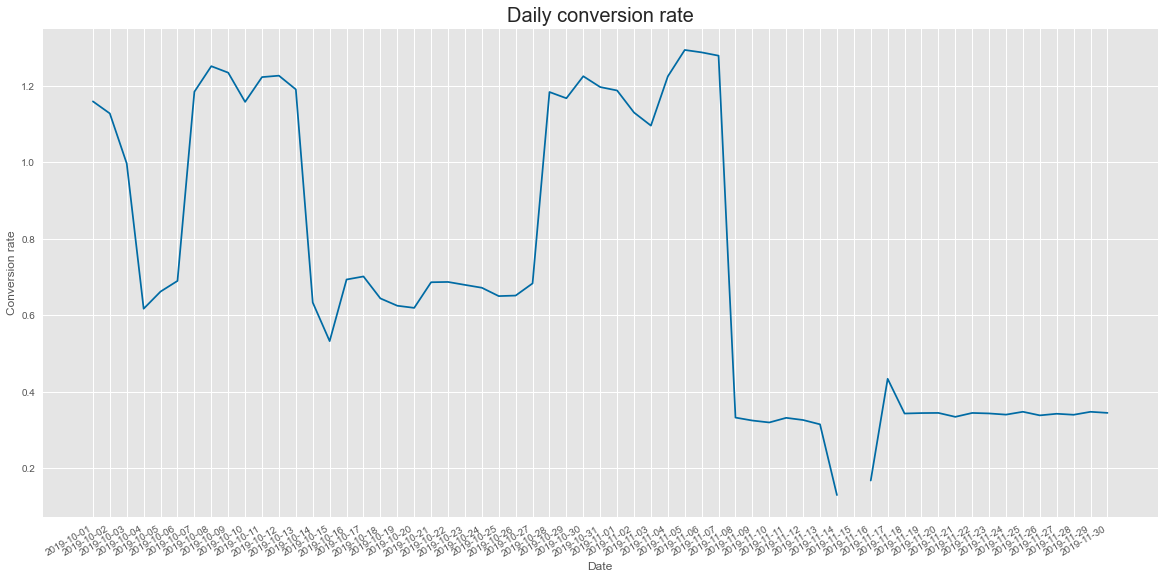

In [ ]:
# Plot daily conversion rate

# Create df for plotting
x = df[['date','event_type']].groupby('date').value_counts().reset_index()
pivot_df = x.pivot(index='date', columns='event_type').reset_index()
pivot_df['daily_conversion_rate'] = pivot_df[0]['purchase']/pivot_df[0]['cart']

# Create line plot
fig = plt.figure(figsize=(20,10))
plt.plot(pivot_df['date'],pivot_df['daily_conversion_rate'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Conversion rate', fontsize=12)
plt.title('Daily conversion rate', fontsize=20)
fig.autofmt_xdate()
plt.show()

In [ ]:
pivot_df[['date','daily_conversion_rate']][40:]

,date,daily_conversion_rate
event_type,,
40,2019-11-10,0.319570
41,2019-11-11,0.331688
42,2019-11-12,0.325989
43,2019-11-13,0.314696
44,2019-11-14,0.129781
45,2019-11-15,NaN
46,2019-11-16,0.167775
47,2019-11-17,0.433772
48,2019-11-18,0.343005


                  day       0                    daily_conversion_rate
event_type               cart purchase      view                      
1              Monday  369177   201246  12168718              0.545121
5             Tuesday  372188   211303  13306627              0.567732
6           Wednesday  369503   216416  13127141              0.585695
4            Thursday  468259   210222  13904159              0.448944
0              Friday  884433   207510  17722564              0.234625
2            Saturday  773266   259477  17827048              0.335560
3              Sunday  718620   353614  16279252              0.492074



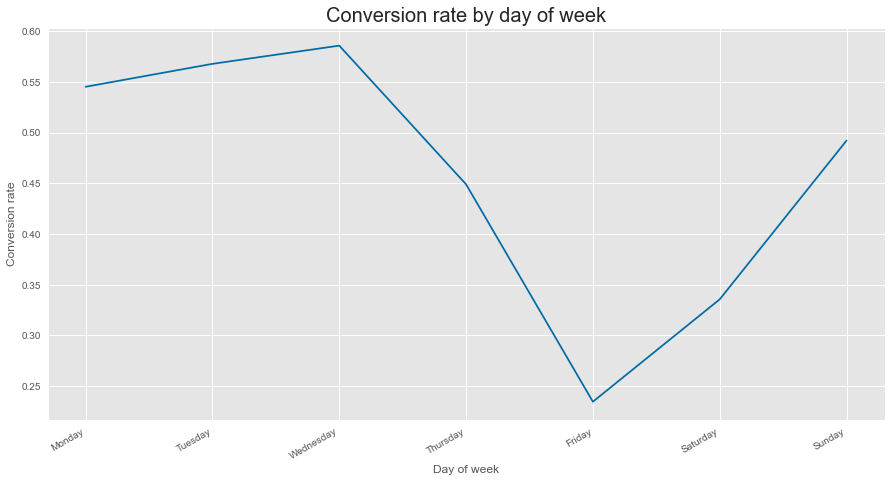

In [ ]:
# Plot conversion rate by day of week

# Create df for plotting
x = df[['day','event_type']].groupby('day').value_counts().reset_index()
pivot_df = x.pivot(index='day', columns='event_type').reset_index()
pivot_df['daily_conversion_rate'] = pivot_df[0]['purchase']/pivot_df[0]['cart']

# Order by day of week
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot_df['day'] = pd.Categorical(pivot_df['day'], categories=days, ordered=True)
pivot_df = pivot_df.sort_values('day')

# Display table
print(pivot_df)
print()

# Create line plot
fig = plt.figure(figsize=(15,8))
plt.plot(pivot_df['day'],pivot_df['daily_conversion_rate'])
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Conversion rate', fontsize=12)
plt.title('Conversion rate by day of week', fontsize=20)
fig.autofmt_xdate()
plt.show()

### Category analysis

                category        0                   
event_type                   cart purchase      view
0            accessories     8060     3741    616475
1                apparel    54290    22217   4477518
2             appliances   445181   174022  12837916
3                   auto    48229    21339   2157706
4              computers   145266    62332   6297977
5           construction    46727    16500   1759762
6           country_yard      421      132     31255
7            electronics  2198460   916667  37026582
8              furniture    43896    19843   3295250
9                   kids    23353    11648   1292002
10              medicine     1796      654     34738
11                  none   932219   407643  34073918
12                 sport     6798     2725    415087
13            stationery      750      325     19323



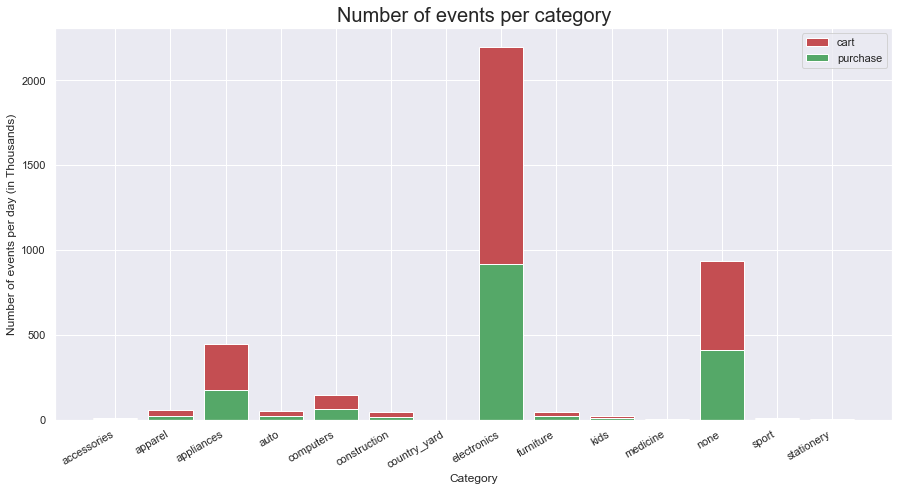

In [ ]:
# Plot counts of cart and purchase events per category

x = df[['category','event_type']].groupby('category').value_counts().reset_index()
pivot_df = x.pivot(index='category', columns='event_type').reset_index()

# Display table
print(pivot_df)
print()

# Create stacked bar chart
fig = plt.figure(figsize=(15,8))
#plt.bar(pivot_df['category'], pivot_df[0]['view']/1e3, color='b') # event_type = view
plt.bar(pivot_df['category'], pivot_df[0]['cart']/1e3, color='r') # event_type = cart
plt.bar(pivot_df['category'], pivot_df[0]['purchase']/1e3, color='g') # event_type = purchase
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of events per day (in Thousands)', fontsize=12)
plt.title('Number of events per category', fontsize=20)
plt.legend(labels=['cart','purchase'])
fig.autofmt_xdate()
plt.show()

                category        0                    category_conversion_rate
event_type                   cart purchase      view                         
0            accessories     8060     3741    616475                 0.464144
1                apparel    54290    22217   4477518                 0.409228
2             appliances   445181   174022  12837916                 0.390902
3                   auto    48229    21339   2157706                 0.442452
4              computers   145266    62332   6297977                 0.429089
5           construction    46727    16500   1759762                 0.353115
6           country_yard      421      132     31255                 0.313539
7            electronics  2198460   916667  37026582                 0.416959
8              furniture    43896    19843   3295250                 0.452046
9                   kids    23353    11648   1292002                 0.498780
10              medicine     1796      654     34738            

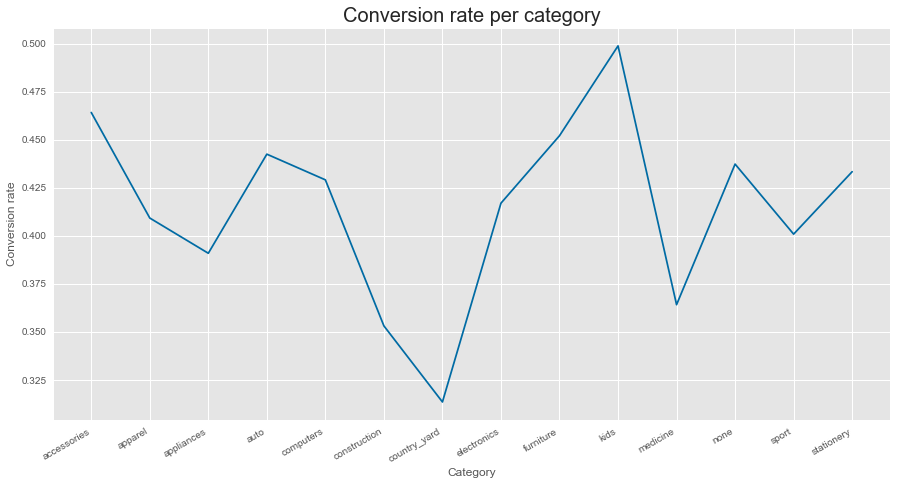

In [ ]:
# Plot conversion rate per category

# Create df for plotting
x = df[['category','event_type']].groupby('category').value_counts().reset_index()
pivot_df = x.pivot(index='category', columns='event_type').reset_index()
pivot_df['category_conversion_rate'] = pivot_df[0]['purchase']/pivot_df[0]['cart']

# Display table
print(pivot_df)
print()

# Create line plot
fig = plt.figure(figsize=(15,8))
plt.plot(pivot_df['category'],pivot_df['category_conversion_rate'])
plt.xlabel('Category', fontsize=12)
plt.ylabel('Conversion rate', fontsize=12)
plt.title('Conversion rate per category', fontsize=20)
fig.autofmt_xdate()
plt.show()

### Relevant queries ran on BigQuery

In [ ]:
# Get top categories arranged by shopping cart conversion rate
SELECT category_code,
sum(case when event_type='purchase' then 1 else 0 end)/NULLIF(sum(case when event_type='cart' then 1 else 0 end),0) as convrate
FROM
`data.container`
GROUP BY category_code
ORDER BY sum(case when event_type='cart' then 1 else 0 end) DESC

In [ ]:
# Get top brands by number of purchase events
SELECT brand,
sum(case when event_type='purchase' then 1 else 0 end) as purchase
FROM
`data.container`
GROUP BY brand
ORDER BY purchase DESC

In [ ]:
# Get users with shopping cart conversion rate > 0.335
SELECT user_id,
sum(case when event_type='purchase' then 1 else 0 end)/NULLIF(sum(case when event_type='cart' then 1 else 0 end),0) AS convrate
FROM
`data.container`
GROUP BY user_id
HAVING convrate > 0.335

In [ ]:
# Get average purchase price
SELECT avg(price)
FROM
`data.container`
WHERE
event_type='purchase'